In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report
from tabulate import tabulate
import joblib


In [2]:

def print_avg_and_mean(dict):
    # Ponderado
    weighted_avg_precision = dict['weighted avg']['precision']
    weighted_avg_recall = dict['weighted avg']['recall']
    weighted_avg_f1_score = dict['weighted avg']['f1-score']
    weighted_avg_support = dict['weighted avg']['support']

    # Aritmético
    mean_precision = np.mean([dict[label]["precision"] for label in dict.keys() if label != "accuracy"])
    mean_recall = np.mean([dict[label]["recall"] for label in dict.keys() if label != "accuracy"])
    mean_f1_score = np.mean([dict[label]["f1-score"] for label in dict.keys() if label != "accuracy"])
    mean_support = np.mean([dict[label]["support"] for label in dict.keys() if label != "accuracy"])

    print(f'Média Ponderada - Precisão: {weighted_avg_precision}')
    print(f'Média Ponderada - Recall: {weighted_avg_recall}')
    print(f'Média Ponderada - F1-Score: {weighted_avg_f1_score}')
    print(f'Média Ponderada - Support: {weighted_avg_support}')
    print('--------------------------------------------------')
    print(f'Média Aritmética - Precisão: {mean_precision}')
    print(f'Média Aritmética - Recall: {mean_recall}')
    print(f'Média Aritmética - F1-Score: {mean_f1_score}')
    print(f'Média Aritmética - Support: {mean_support}')


In [3]:

# Definindo o valor das seeds para garantir reprodutibilidade
RANDOM_SEED = 42
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Carregar os dados de treino e teste
mitbih_train = pd.read_csv('mitbih_test.csv', header=None)
mitbih_test = pd.read_csv('mitbih_train.csv', header=None)

# Separar os conjuntos de treino e teste 
x_train = mitbih_train.iloc[:, :-1].values
y_train = mitbih_train.iloc[:, -1].values

# Variáveis para teste e validação (50% teste - 50% validação)
X_test, X_val, y_test, y_val = train_test_split(
    mitbih_test.iloc[:, :-1].values, 
    mitbih_test.iloc[:, -1].values, 
    test_size=0.5, 
    random_state=RANDOM_SEED
)


In [4]:

# Criar o pipeline para padronização e treinamento do modelo MLP
mlp_pipeline = make_pipeline(StandardScaler(), MLPClassifier(random_state=RANDOM_SEED))

# Treinamento do modelo
mlp_pipeline.fit(x_train, y_train)

# Previsão com base no conjunto de validação
y_pred_val = mlp_pipeline.predict(X_val)

In [5]:
# Gerar relatório de classificação da Validação
report = classification_report(y_val, y_pred_val, target_names=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'])
print(f'Relatório de Classificação MLP (Validação):\n{report}')
cm = confusion_matrix(y_val, y_pred_val)

Relatório de Classificação MLP (Validação):
              precision    recall  f1-score   support

    Classe 1       0.98      0.99      0.98     36284
    Classe 2       0.77      0.67      0.72      1066
    Classe 3       0.90      0.90      0.90      2876
    Classe 4       0.79      0.48      0.60       324
    Classe 5       0.97      0.97      0.97      3227

    accuracy                           0.97     43777
   macro avg       0.88      0.80      0.84     43777
weighted avg       0.97      0.97      0.97     43777



Matriz de Confusão MLP (Validação):
[[35833   189   176    27    59]
 [  319   718    26     0     3]
 [  228    20  2589    14    25]
 [   99     1    67   157     0]
 [   68     2    23     0  3134]]


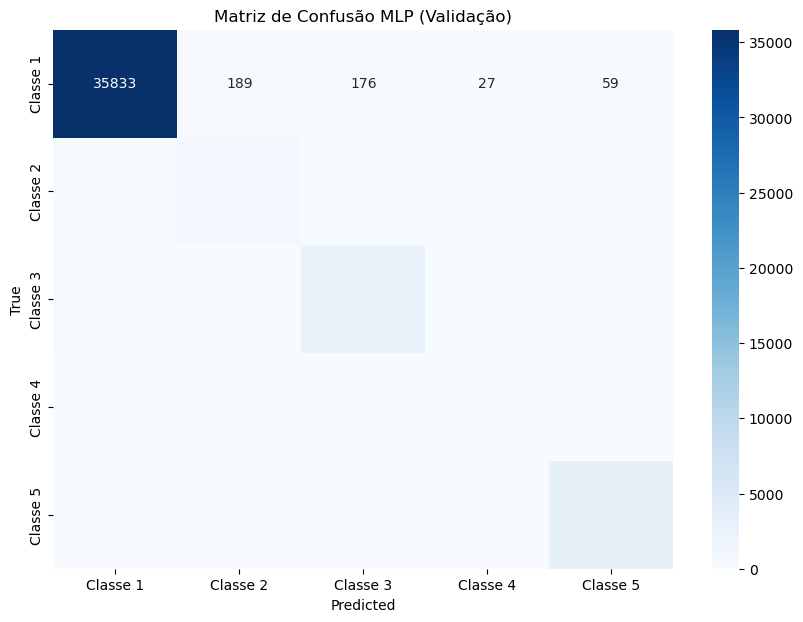

In [6]:
# Gerar e plotar a matriz de confusão da Validação
print(f'Matriz de Confusão MLP (Validação):\n{cm}')
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'], yticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Matriz de Confusão MLP (Validação)')
plt.show()


In [7]:

# Definir o grid de hiperparâmetros para MLP
param_grid = {
    'mlpclassifier__hidden_layer_sizes': [(50,), (100,), (150,)],  # Tamanhos das camadas escondidas
    'mlpclassifier__activation': ['tanh', 'relu'],  # Função de ativação
    'mlpclassifier__solver': ['sgd', 'adam'],       # Otimizadores
    'mlpclassifier__alpha': [0.0001, 0.001, 0.01],  # Parâmetro de regularização L2
    'mlpclassifier__learning_rate': ['constant', 'adaptive'],  # Taxa de aprendizado
}

In [ ]:
# Configurar o GridSearchCV
grid_search = GridSearchCV(estimator=mlp_pipeline, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Executar o GridSearchCV no conjunto de teste
grid_search.fit(X_test, y_test)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [ ]:
# Exibir os melhores parâmetros encontrados
print(f'Melhores hiperparâmetros: {grid_search.best_params_}')

# Treinar o modelo com os melhores parâmetros encontrados
best_mlp = grid_search.best_estimator_

# Previsão com o modelo ajustado no conjunto de teste
y_pred_test = best_mlp.predict(X_test)


In [ ]:
# Gerar relatório de classificação
report = classification_report(y_test, y_pred_test, target_names=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'])
print(f'Relatório de Classificação MLP (Teste):\n{report}')
cm = confusion_matrix(y_test, y_pred_test)

In [ ]:
# Gerar e plotar a matriz de confusão
print(f'Matriz de Confusão MLP (Teste):\n{cm}')
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'], yticklabels=['Classe 1', 'Classe 2', 'Classe 3', 'Classe 4', 'Classe 5'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Matriz de Confusão MLP (Teste)')
plt.show()